# Praxisteil I: Bayessche Lineare Modelle (Lösung)

__Bayesian Workflow__

1. Problemstellung
2. Exploration der Daten
3. Bauen des Modells
4. Posterior Inference (Model Fitting)
5. Posterior Predictive Check
6. Parameter Inferenz
7. Modell verbessern

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az
import numpy as np

import math
import warnings
warnings.filterwarnings('ignore')

kwargs_sampler = {'chains': 4,'cores': 4}#, 'return_inferencedata': True}

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
# Plotting functions
def plot_model_with_hdi(df,ppc,beta_0_est,beta_1_est):
    plt.figure(figsize=(16,8))
    az.plot_hdi(df['Price'], ppc['sales_pred'],color='gray',figsize=(16,8))
    plt.plot(df['Price'],df['Sales'],'.b')
    plt.plot(df['Price'], beta_0_est + beta_1_est*df['Price'],c='k')
    plt.xlabel('Price')
    plt.ylabel('Sales')

def plot_data(df,fit=False): 
    plt.figure(figsize=(16,8))
    if fit:
        coef = np.polyfit(df['Price'],df['Sales'],1)
        plt.plot(df['Price'],df['Sales'],'.b')
        plt.plot(df['Price'], coef[1] + coef[0]*df['Price'],c='k')
    else:
        plt.scatter(df['Price'],df['Sales'])
    plt.xlabel('Price', fontsize=20)
    plt.ylabel('Sales', fontsize=20)

## Problemstellung

Du wurdest beauftragt den Absatz des Unternehmens vorherzusagen.

Als erfahrener Bayesianer machst du dich ans Werk und überlegst dir, was den größten Einfluss auf den Absatz haben könnte. Nach deiner Recherche stellst du die Hypothese auf, dass der Preis wahrscheinlich den größten Einfluss hat und dieser negativ auf den Absatz wirkt. Diese Hypothese willst du mit einem ersten Modell überprüfen.

Die Daten hast du bereits gequeried.

## Exploration der Daten

In [5]:
# Load data
df = pd.read_csv('../../data/dataset_sim.csv')
df.head()

,Sales,Price,Store
0,48.484536,5.749164,0
1,43.640838,4.796067,0
2,48.609230,4.817825,0
3,45.924189,5.680656,0
4,57.832635,3.181501,0


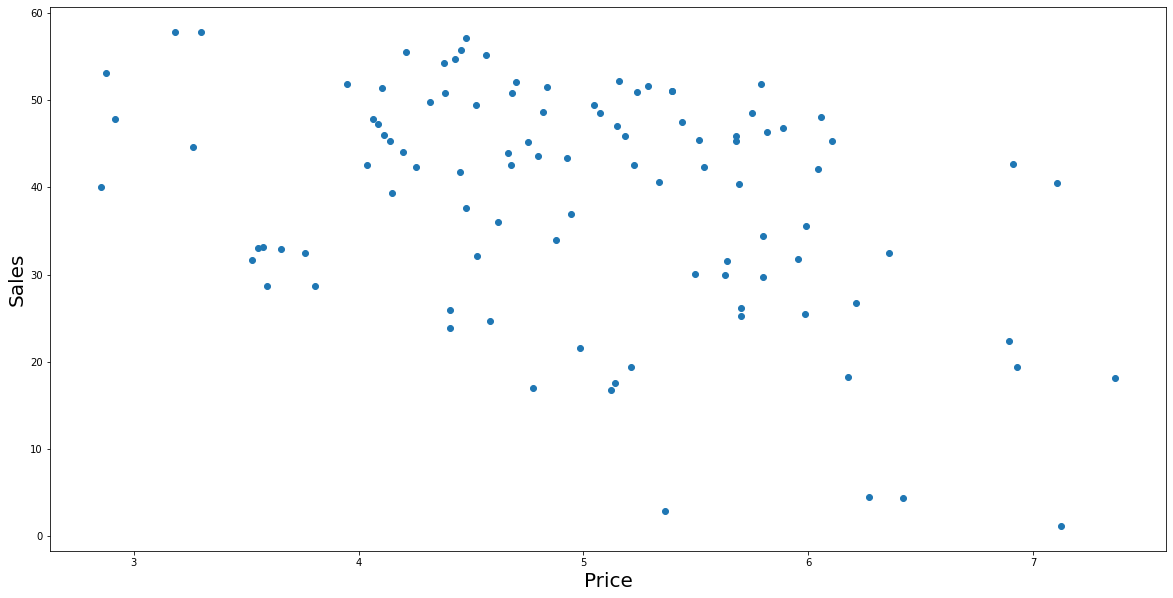

In [12]:
plot_data(df)

## Bauen des Modells

### Bayessches Lineares Modell

Du stellst das folgende probabilistische Modell auf, das den Absatz als bedingte Normalverteilung beschreibt:

$$
\begin{align}
y|X\beta &\sim N(\mu,\epsilon) \\
y &\sim N(X\beta,\epsilon)
\end{align}
$$

oder in diesem Falle konkret:

$$
s \sim N(\mu=\beta_0 + \beta_1 p,\epsilon)
$$

### Prior Distributions

Es gilt die Parameter $\beta_0$ und $\beta_1$ zu schätzen. In der Bayesschen Statistik werden ALLE Unbekannten mit einer Verteilung über ihre möglichen, plausiblen Werte beschrieben. Diese wird A-Priori-Verteilung genannt. 

In diesem Falle gilt es also Verteilungen für $\beta_0$, $\beta_1$ und $\epsilon$ zu finden. Eine Möglichkeit wäre:

$$
\begin{align}
\beta_0 &\sim N(\mu_{\beta_0}, \sigma_{\beta_0}) \\
\beta_1 &\sim N(\mu_{\beta_1}, \sigma_{\beta_1}) \\
\epsilon &\sim |N(0, \sigma_{\epsilon})| \\
\end{align}
$$

Wobei du bereits deine Annahme eines negativen Zusammenhangs in die Priors einbauen kannst, indem du $\mu_{\beta_1}<0$ setzt.

### Pymc3 implementierung

Dieses Modell wird in pymc3 wie folgt gebaut:

In [6]:
with pm.Model() as linear_model:
    
    # Hyperparameters
    beta_0 = pm.Normal('beta_0', mu=0, sd=100)
    beta_1 = pm.Normal('beta_1', mu=-20, sd=50)
    eps = pm.HalfNormal('eps', 5)
    
    # Calculate conditional mean of normal distribution 
    mu = beta_0 + beta_1*df['Price']
    
    # Conditional normal distribution
    sales_pred = pm.Normal('sales_pred',mu=mu,sd=eps,observed=df['Sales'])

In [ ]:
# Visualize the model
pm.model_to_graphviz(hierarchical_linear_model)

## Posterior Inference (Model Fitting)

### Sampling from the posterior

In [7]:
with linear_model:
    # Sample from the model
    trace_linear_model = pm.sample(**kwargs_sampler)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


### Convergence Check

More information about MCMC sampling and convergence diagnostics: https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html

array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_0'}>],
       [<AxesSubplot:title={'center':'beta_1'}>,
        <AxesSubplot:title={'center':'beta_1'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

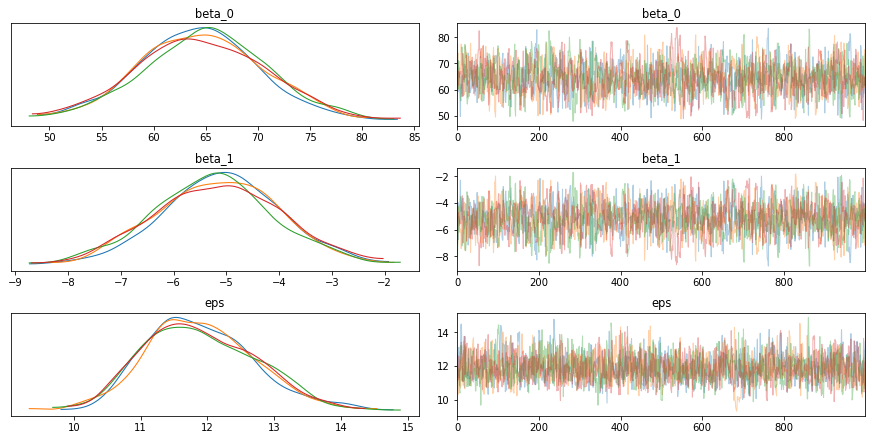

In [8]:
# Analyze the results
az.plot_trace(trace_linear_model)

In [49]:
# Tabular summary
az.summary(trace_linear_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_0,64.267,6.308,52.958,77.094,0.187,0.132,1142.0,1142.0,1139.0,1354.0,1.0
beta_1,-5.084,1.247,-7.323,-2.536,0.037,0.026,1163.0,1163.0,1166.0,1306.0,1.0
eps,11.878,0.813,10.336,13.299,0.018,0.013,1983.0,1945.0,2040.0,1920.0,1.0


## Posterior Predictive Check

In [52]:
# Predict observations from the model by posterior predictive sampling
with linear_model:
    ppc_lm = pm.sample_posterior_predictive(trace_linear_model, random_seed=58)

<AxesSubplot:xlabel='sales_pred'>

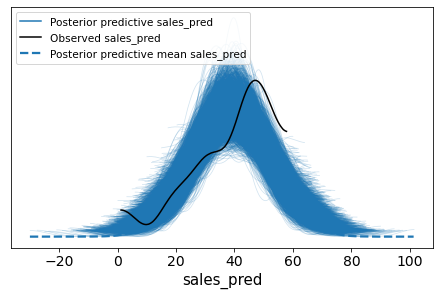

In [56]:
# Alternatively we can use the plot the conditional distribution of y
idata = az.from_pymc3(trace_linear_model, posterior_predictive=ppc_lm)
az.plot_ppc(idata)

## Parameter Inference

### Posterior distributions

array([<AxesSubplot:title={'center':'beta_0'}>,
       <AxesSubplot:title={'center':'beta_1'}>,
       <AxesSubplot:title={'center':'eps'}>], dtype=object)

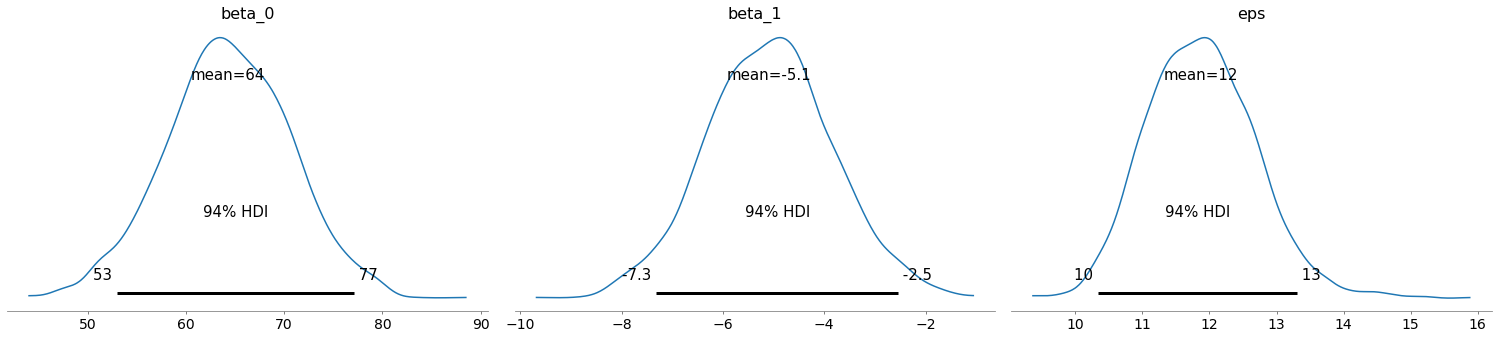

In [61]:
az.plot_posterior(trace_linear_model) 

In [ ]:
# Beta estimate from posterior distribution
beta_0_est = trace_linear_model['beta_0'].mean()
beta_1_est = trace_linear_model['beta_1'].mean()

In [ ]:
# Plot fitted model with 94 CI
plot_model_with_hdi(df,ppc_lm,beta_0_est,beta_1_est)

### Exkurs: MLE / MAP Estimate

In [1]:
# The estamates of the parameters are the mean of all samples
eps_est = trace_linear_model['eps'].mean()

print(f'BAY beta_0_est: {beta_0_est}')
print(f'BAY beta_1_est: {beta_1_est}')
print(f'BAY eps_est: {eps_est}')

NameError: name 'trace_linear_model' is not defined

In [63]:
# Compaison with MLE Estimate
b, m = np.polynomial.polynomial.polyfit(df['Price'], df['Sales'], 1)
print(f'MLE beta_0_est: {b}')
print(f'MLE beta_1_est: {m}')

MLE beta_0_est: 64.71252172983745
MLE beta_1_est: -5.174890374445355


## Conclusion

In [12]:
with linear_model:
    pm.save_trace(trace_linear_model,'../models/linear_model',overwrite=True)